In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/jazzer/.pyenv/versions/3.6.10/bin/python (found version "3.6.10") 
-- Found PythonLibs: /home/jazzer/.pyenv/versions/3.6.10/lib/libpython3.6m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/jazzer/Facultad/metodos_numericos_3/mt/tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/jazzer/

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng           

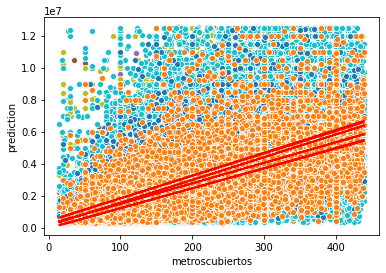

In [4]:
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))

def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)
    
    t0 = time.time()

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]
    
    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)
    
    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

print(df.info()) 

# df['centroscomercialescercanos'].hist()

df_bu = df.copy()
df_bu = df_bu[df_bu['centroscomercialescercanos'] == 1 ]
df_bu = df_bu[df_bu['escuelascercanas']==1]

df_mu = df.copy()
df_mu = df_mu[df_mu['centroscomercialescercanos'] == 0 ]
df_mu = df_mu[df_mu['escuelascercanas']==0]

df_sbu1 = df.copy()
df_sbu1 = df_sbu1[df_sbu1['centroscomercialescercanos'] == 1]
df_sbu1 = df_sbu1[df_sbu1['escuelascercanas']==0]

df_sbu2 = df.copy()
df_sbu2 = df_sbu2[df_sbu2['centroscomercialescercanos'] == 0 ]
df_sbu2 = df_sbu2[df_sbu2['escuelascercanas']==1]

df_bu.info()
df_mu.info()
df_sbu1.info()
df_sbu2.info()
# df['garages'].hist()

d_bu = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
d_mu = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
d_sbu1 = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
d_sbu2 = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./test_buena_ubicacion_{}'.format(int(time.time()))
os.mkdir(folder)

for j in np.arange(1,2,1):
    for i in np.arange(0.6, 0.96, 0.05):
        print(i)
        df_prediction_bu = experiment(i, 'precio', ['metroscubiertos'], j*int(i*100), df_bu, d_bu)
        df_prediction_bu.to_csv(folder+'/prediction_bu'+'_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', index=False)
        
        df_prediction_mu = experiment(i, 'precio', ['metroscubiertos'], j*int(i*100), df_mu, d_mu)
        df_prediction_mu.to_csv(folder+'/prediction_mu'+'_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', index=False)
        
        df_prediction_sbu1 = experiment(i, 'precio', ['metroscubiertos'], j*int(i*100), df_sbu1, d_sbu1)
        df_prediction_sbu1.to_csv(folder+'/prediction_sbu1'+'_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', index=False)
        
        df_prediction_sbu2 = experiment(i, 'precio', ['metroscubiertos'], j*int(i*100), df_sbu2, d_sbu2)
        df_prediction_sbu2.to_csv(folder+'/prediction_sbu2'+'_'+str(j)+'_'+str(i)+'.csv', encoding='utf-8', index=False)
        print('\n--------------\n')

# (pd.DataFrame(data=d_bu)
#        .to_csv(folder+'/error_bu.csv', encoding='utf-', index=False))
# (pd.DataFrame(data=d_mu)
#        .to_csv(folder+'/error_mu.csv', encoding='utf-', index=False))
# (pd.DataFrame(data=d_sbu1)
#        .to_csv(folder+'/error_sbu1.csv', encoding='utf-', index=False))
# (pd.DataFrame(data=d_sbu2)
#        .to_csv(folder+'/error_sbu2.csv', encoding='utf-', index=False))
